# Business Understanding

This dataset is from a Portuguese financial institution and aims to determine whether potential customers will enter into a term deposit with the bank based on a number of factors. This data was collected through phone calls with potential customers, and is highly valuable information for this institution as well as any other financial institutions across the globe. For example, banks can use this information to identify high-potential customers and allocate their marketing resources more effectively. We believe that an AUC of 0.7 or higher would be valuable information for banks around the world, especially because we are dealing with a somewhat sizable dataset. An AUC of 0.8 or higher would certainly be of use to other institutions. The higher the AUC, the more confident that can be in allocating resources towards certain groups of people.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
import seaborn as sns

from sklearn.impute import KNNImputer

In [43]:
bank_data = pd.read_csv("bank-full.csv", delimiter=";")

# Data Description

In [44]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

**age: int64**
- The age of the potential customer. Ranges from 18 to 95 years old.

**job: object**
- The potential customer's job category. There are 12 total categories of jobs, one of which is "unknown", which we will treat as missing.

**marital: object**
- The potential customer's marital status. This can be "married", "single", or "divorced".

**education: object**
- The education level of the potential customer. The categories for this variable are "secondary", "tertiary", "primary", or "unknown" (which will be treated as missing).

**default: object**
- A binary variable that describes whether or not the potential customer has credit in default. The two factor levels for this variable are "yes" and "no".

**balance: int64**
- The potential customer's average yearly credit balance.

**housing: object**
- Whether or not the potential customer has a housing loan. This can only be "yes" or "no".

**loan: object**
- Whether or not the potential customer has a personal loan. This can only be "yes" or "no".

**contact: object**


In [45]:
bank_data.loan.value_counts()

loan
no     37967
yes     7244
Name: count, dtype: int64

# Data Quality

### Duplicate Data

In [46]:
sum(bank_data.duplicated())

0

The above code shows that there are no duplicate rows in our data. The duplicated() function returns a boolean series, and the sum function adds up all the boolean values as True=1 and False=0. Because the sum of the series is 0, we know that there are no duplicates. As a result, no rows need to be removed due to duplication.

### Missing Data

In [47]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

The above code shows that are data has no null values. However, this does not mean that we have no missing data, as missing data can be "unknown" in categorical variables.

In [48]:
cat_vars = ["job", "marital", "education",
            "default", "housing", "loan",
            "contact", "day", "month",
           "poutcome"]

for x in cat_vars:
    print(bank_data[x].value_counts())

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
default
no     44396
yes      815
Name: count, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64
loan
no     37967
yes     7244
Name: count, dtype: int64
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
day
20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27 

From the above output, we can see that "job", "education", "contact", and "poutcome" all have "unknown" values. These will either need to be imputed or removed from the data.

In [49]:
# Convert all "unknown" values to null
df = bank_data.replace("unknown", np.nan)

In [50]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [51]:
df.poutcome.value_counts()

poutcome
failure    4901
other      1840
success    1511
Name: count, dtype: int64

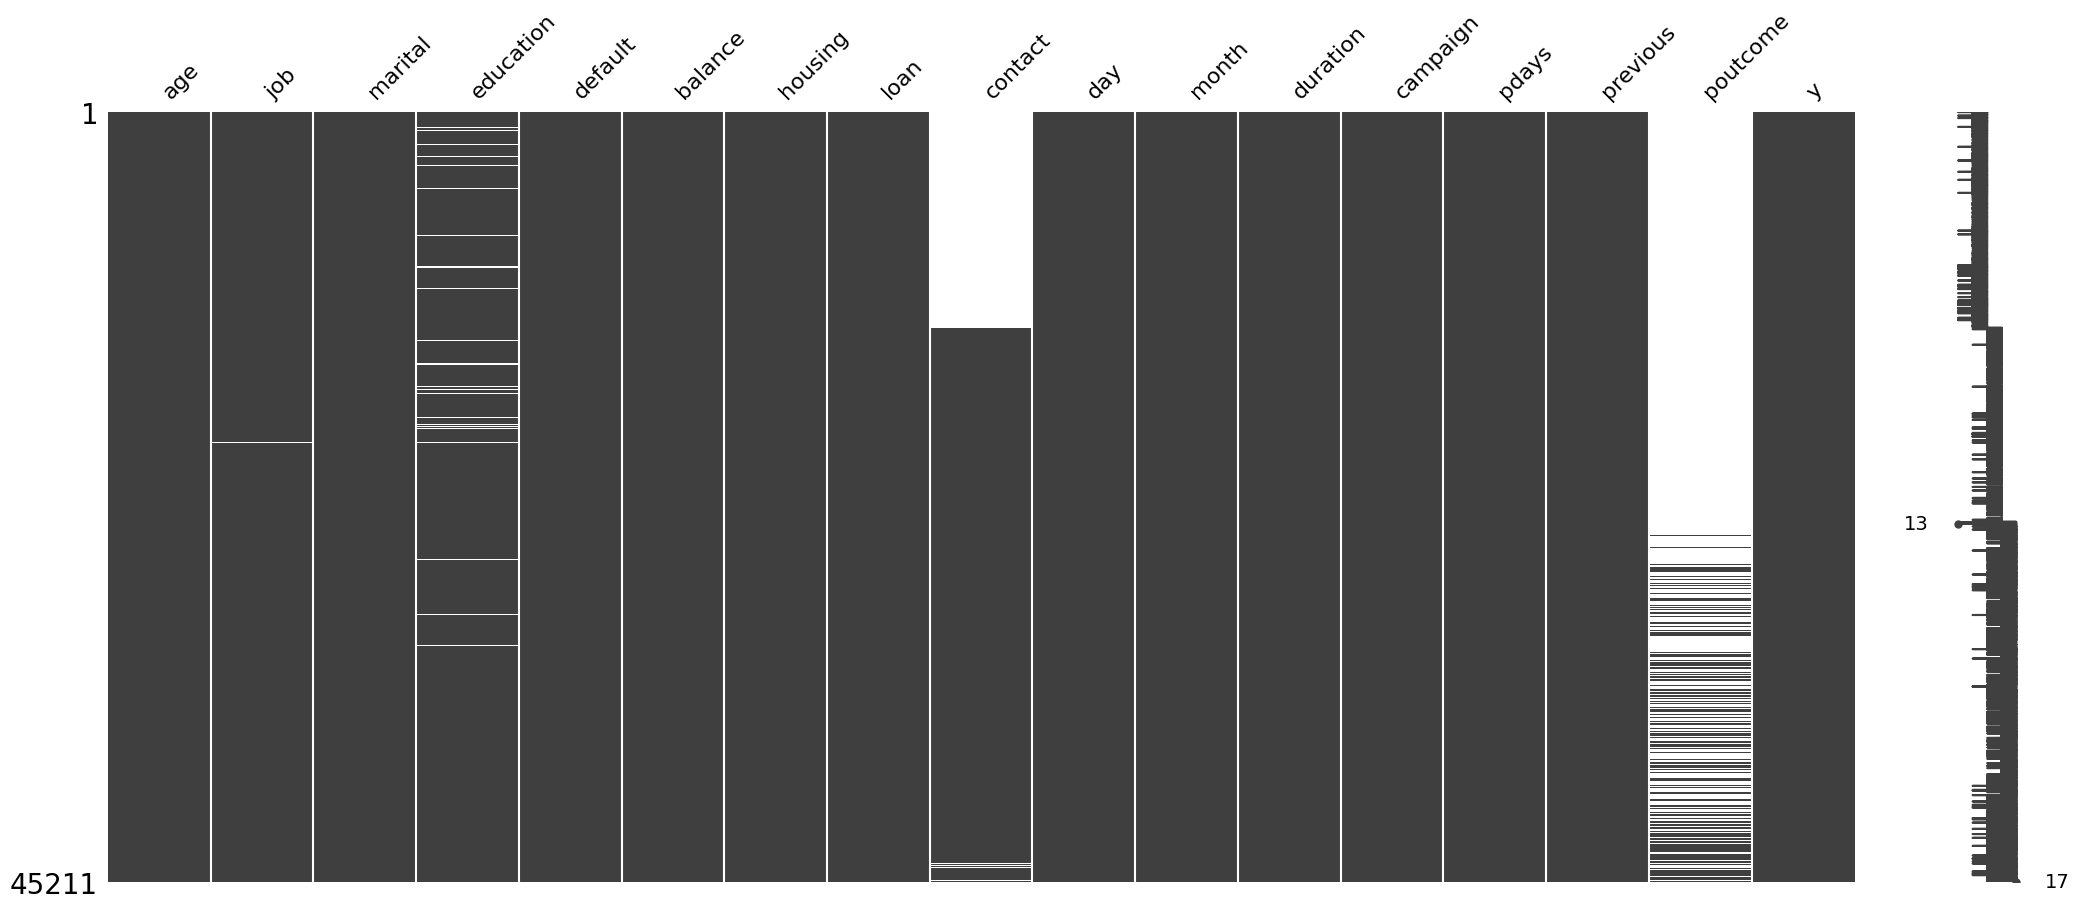

<Figure size 640x480 with 0 Axes>

In [52]:
# Plot missing values
mn.matrix(df) 
plt.figure()
plt.show()

### Job

Given the fact that all missing data are labeled "unkown", it does not seem that the values are missing due to a mistake such as a recording error. It may be the case that these customers did not want to specify their occupation. It is also important to note that there is a factor level for unemployed customers, so we know that "unknown" does not mean "unemployed". Because very few data points are missing for this column, we will use KNN imputation to impute all missing values for job.

### Contact

We will remove the contact column entirely, because this entire dataset consists of data collected through marketing phone call efforts. The only two values that did exist in the column were “cellular” and “telephone”, and almost 90% of these were recorded as “cellular”. At the end of the day, everyone was reached via phone call, so we do not believe this column would add anything to our model.

### POutcome

We are also going to remove the POutcome column, because the vast majority of this data is missing. This column shows results from the previous round of marketing efforts, meaning that the vast majority of these potential customers were not reached during the first round of efforts. With that being said, it would be wrong to impute these all as failures or successes, and may skew our model towards an entirely different outlook.

### Education

There are relatively few missing values in this column. We figure that this column can be imputed with KNN Imputer because it is the safest way to approach this. There is a possibility that these 1800 missing values are uneducated people, but since we are unsure, it is better to impute these values with KNN.

In [53]:
# Remove contact and poutcome from the data
df_to_impute=df.copy()
df_to_impute.drop(columns=["contact", "poutcome"], inplace=True)

In [54]:
df_to_impute.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'y'],
      dtype='object')

### KNN Imputation

Now, let's apply KNN imputation to fill in missing values for the education and contact attributes.

Before applying KNN imputation, we need to select attributes that are related to the missing ones and nomalize them due to ensure accurate distance calculations. Based on domain knowledge, we choose the following attributes and normalize them accordingly:

 - age: Numerical → Scaled
- job: Categorical → One-Hot Encoding
- marital: Categorical → One-Hot Encoding
- education: Categorical → One-Hot Encoding
- default: Binary (yes/no) → Map "yes" to 1, "no" to 0
- balance: Numerical → Scaled
- housing: Binary (yes/no) → Map "yes" to 1, "no" to 0
- loan: Binary (yes/no) → Map "yes" to 1, "no" to 0
- day: Numerical → Scaled
- month: Categorical → Convert to numerical values and scale
- duration: Numerical → Scaled

In [55]:
#nomalize each attribute
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

#pick and nomalize the related attributes
# 1. Apply One-Hot Encoding for categorical attributes
categorical_cols = ["job", "marital", 'education']
df_encoded = pd.concat([pd.get_dummies(df_to_impute[col],prefix=col) for col in categorical_cols], axis=1)
df_copy=df_to_impute.copy()
df_drop = df_copy.drop(columns=categorical_cols)
df_to_impute = pd.concat([df_drop, df_encoded], axis=1)


#2. Binary Mapping for Yes/No Variables
binary_cols = ["default", "housing", "loan"]
for col in binary_cols:
    df_to_impute[col] = df_to_impute[col].map({"yes": 1, "no": 0})

#3. normalize numerical attributes
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df_to_impute["month"] = df_to_impute["month"].map(month_mapping)
scaler = MinMaxScaler()
num_cols = ["age", "balance","day", 'month', "duration"]
df_to_impute[num_cols] = scaler.fit_transform(df_to_impute[num_cols])

In [56]:
# KNN imputation based upon the K closest samples (rows)
from sklearn.impute import KNNImputer
import copy
# set k=7
knn_obj = KNNImputer(n_neighbors=7)
features_to_use =['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary']

# create a numpy matrix from pandas numeric values to impute
temp = df_to_impute[features_to_use].to_numpy()

knn_obj.fit(temp)
temp_imputed = knn_obj.transform(temp)

df_imputed = copy.deepcopy(df_to_impute)
df_imputed[features_to_use] = temp_imputed
df_imputed.dropna(inplace=True)
df_imputed.info()
print(knn_obj.n_features_in_)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  float64
 1   default              45211 non-null  float64
 2   balance              45211 non-null  float64
 3   housing              45211 non-null  float64
 4   loan                 45211 non-null  float64
 5   day                  45211 non-null  float64
 6   month                45211 non-null  float64
 7   duration             45211 non-null  float64
 8   campaign             45211 non-null  int64  
 9   pdays                45211 non-null  int64  
 10  previous             45211 non-null  int64  
 11  y                    45211 non-null  object 
 12  job_admin.           45211 non-null  float64
 13  job_blue-collar      45211 non-null  float64
 14  job_entrepreneur     45211 non-null  float64
 15  job_housemaid        45211 non-null 

In [57]:
# Reverse One-Hot Encoding for 'job' and 'education'
# job
df_imputed_reversed=df.copy()
job_categories = [col for col in df_imputed.columns if col.startswith("job_")]
df_imputed_reversed["job"] = df_imputed[job_categories].idxmax(axis=1).str.replace("job_", "")

# 'education'
education_categories = [col for col in df_imputed.columns if col.startswith("education_")]
df_imputed_reversed["education"] = df_imputed[education_categories].idxmax(axis=1).str.replace("education_", "")

df_imputed_reversed.drop(columns=["contact", "poutcome"], inplace=True)

df_imputed_reversed.info()
df_imputed_reversed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   day        45211 non-null  int64 
 9   month      45211 non-null  object
 10  duration   45211 non-null  int64 
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no
3,47,blue-collar,married,primary,no,1506,yes,no,5,may,92,1,-1,0,no
4,33,admin.,single,primary,no,1,no,no,5,may,198,1,-1,0,no


In [58]:
df.info()
df_imputed_reversed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 

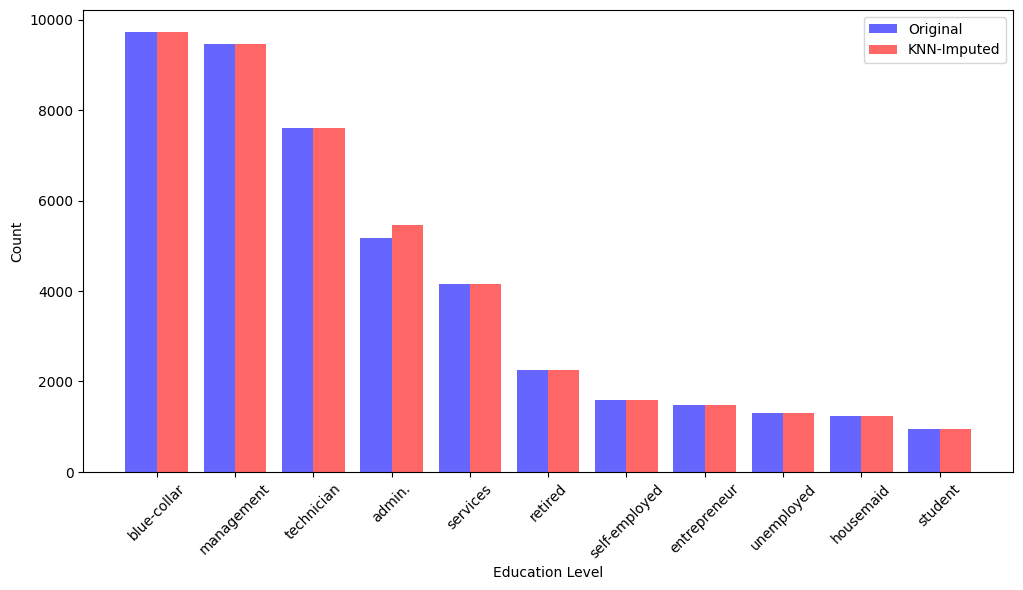

In [59]:
# Count occurrences of each education category
original_counts = df["job"].value_counts()
imputed_counts = df_imputed_reversed["job"].value_counts()

# Create bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of bars

# Positions for bars
index = np.arange(len(original_counts))

# Plot original and imputed data side by side
plt.bar(index, original_counts.values, bar_width, label="Original", color="blue", alpha=0.6)
plt.bar(index + bar_width, imputed_counts.values, bar_width, label="KNN-Imputed", color="red", alpha=0.6)

# Label the axes
plt.xlabel("Education Level")
plt.ylabel("Count")

# Set x-axis labels
plt.xticks(index + bar_width / 2, original_counts.index, rotation=45)

plt.legend()

plt.show()

# Data Visualization

### Balance

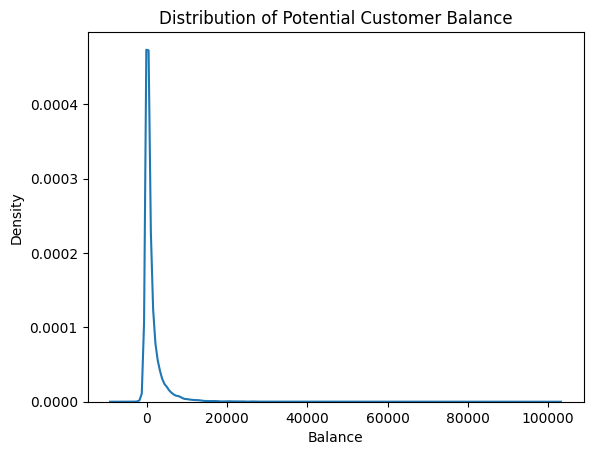

In [60]:
ax = sns.kdeplot(df.balance)
ax.set_xlabel("Balance")
ax.set_title("Distribution of Potential Customer Balance")
plt.show()

### Month

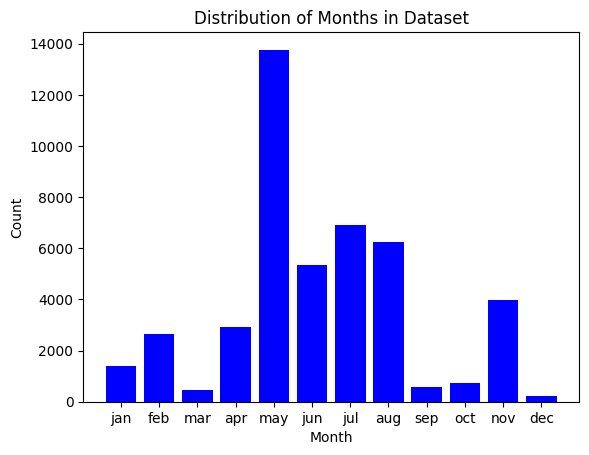

In [61]:
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
month_counts = df['month'].value_counts()
month_counts = month_counts.reindex(month_order)
 
plt.bar(month_counts.index, month_counts.values, color="blue")
 
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of Months in Dataset")
 
plt.show()

### Education

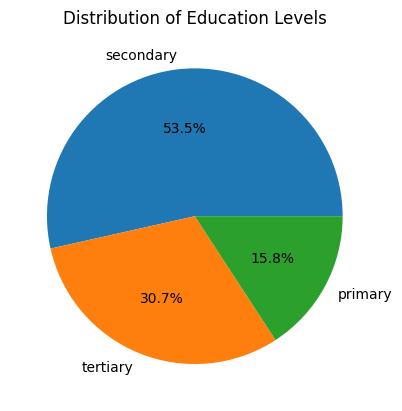

In [62]:
education_counts = df['education'].value_counts()
 
plt.pie(education_counts.values, labels=education_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Education Levels")
plt.show()

### Marital

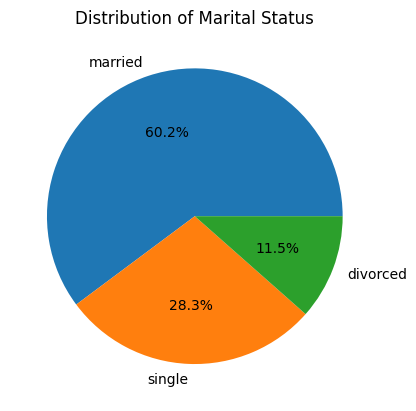

In [63]:
marital_counts = df['marital'].value_counts()
 
plt.pie(marital_counts.values, labels=marital_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Marital Status")
plt.show()

### Age

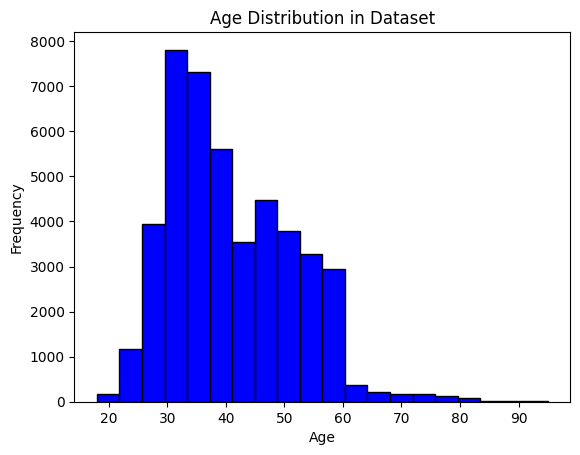

In [64]:
plt.hist(df['age'], bins=20, edgecolor='black', color='blue')
 
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution in Dataset")
 
plt.show()

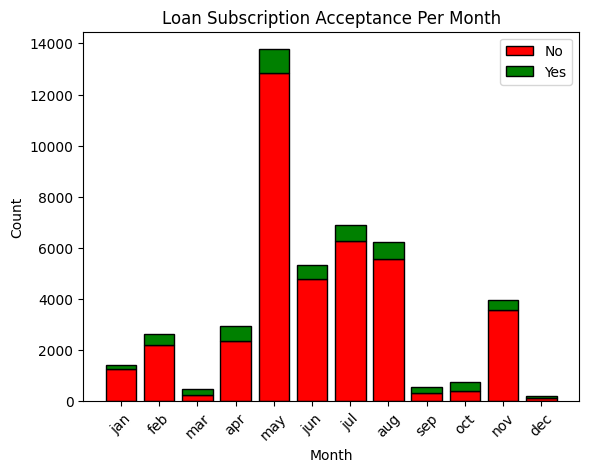

In [65]:
month_counts = df.groupby(['month', 'y']).size().unstack(fill_value=0)
month_counts = month_counts.reindex(month_order)
bar1 = plt.bar(month_counts.index, month_counts["no"], color="red", edgecolor="black", label="No")
bar2 = plt.bar(month_counts.index, month_counts["yes"], bottom=month_counts["no"], color="green", edgecolor="black", label="Yes")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Loan Subscription Acceptance Per Month")
plt.xticks(rotation=45)
plt.legend()

plt.show()
 